In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
first_layer_filters = {
    'Edge Enhancement': np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]),
    'Horizontal Edge Detection': np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]]),
    'Vertical Edge Detection': np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
}

In [4]:
second_layer_filters = {
    'Gaussian Blur': np.array([[1, 4, 7, 4, 1], [4, 16, 26, 16, 4], [7, 26, 41, 26, 7], [4, 16, 26, 16, 4], [1, 4, 7, 4, 1]]) ,
    'Large Edge Enhancement': np.array([[0,  0, -1,  0,  0], [0, 0, -1, 0,  0], [-1, -1, 8, -1, -1], [0, 0, -1, 0,  0], [0,  0, -1,  0,  0]])
}


<div style="text-align: right;", dir="rtl">
ابتدا فايل عكس ورودي را دريافت كرده و آن را نمايش ميدهيم.

سپس لا استفاده از كتابخانه CV2 آن را به فرم rgb در اورده و در  نهايت آن را به سايز خواسته شده(600x600) تبديل ميكنيم و نمايشش ميدهيم.
</div>

shape of the oroginal image:(height,width,number of BGR color channels) (450, 600, 3)


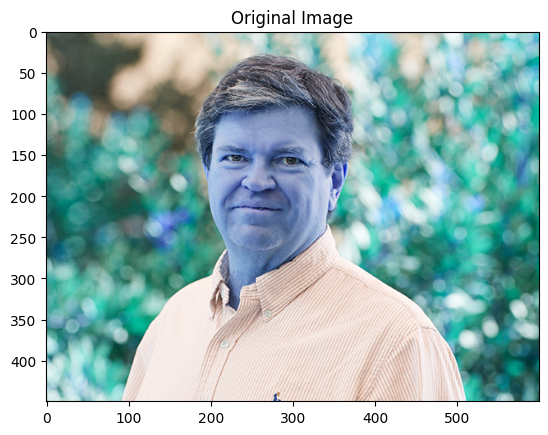

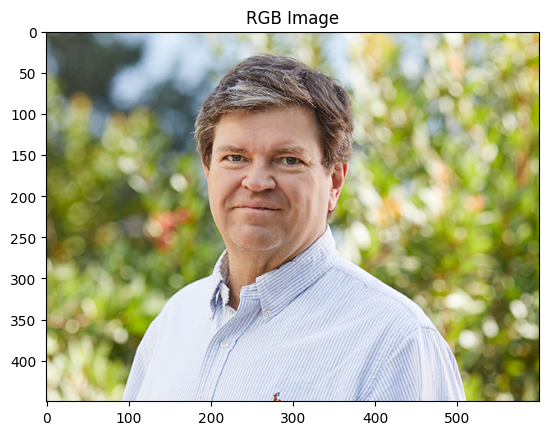

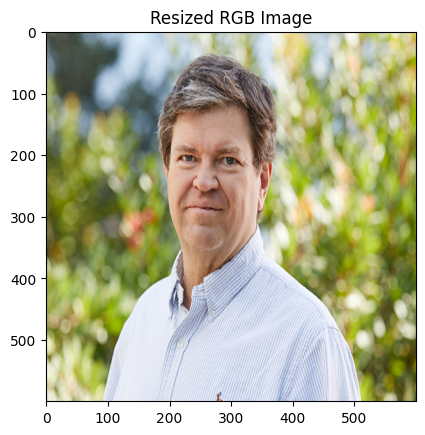

In [5]:
# Load the image
image_path = r'C:\Users\parmiss\Desktop\University\Signal\Final Project_Image Processing\yann_lecun.jpg'
#returns a 3D NumPy array of shape (height, width, 3). Each element of the array represents a pixel, and the three channels correspond to the Blue, Green, and Red (BGR) color values of that pixel.
original_image = cv2.imread(image_path)
print("shape of the oroginal image:(height,width,number of BGR color channels)",original_image.shape)
plt.imshow(original_image)
plt.title('Original Image')
plt.show()
rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert to RGB
plt.imshow(rgb_image)
plt.title('RGB Image')
plt.show()
resized_rgb_image = cv2.resize(rgb_image,(600,600))
plt.imshow(resized_rgb_image)
plt.title('Resized RGB Image')
plt.show()


<div style="text-align: right;", dir="rtl">
در ادامه تابعي براي انجام محاسبات كانولوشن داريم.

اين تابع با دريافت عكس، كرنل، مقدار پيشروي و نوع پدينگ، ابندا با دريافت مقادير مورد نياز همچون طول و عرض عكس اوليه و  تعداد كانال ها و همچنين اطلاعات مشابه براي كرنل، با استفاده از فرمول داده شده در اسلايدها اقدام به محاسبه طول و عرض خروجي ميكند.

سپس با چك كردن توع پدينگ در صورت نياز خروجي مناسب را ميدهد . در آخر محاسبه كانولوشن را براي پيكسل هاي مربوطه در خروجي براي هر كانال انجام ميدهيم.
</div>

In [6]:
def apply_convolution(image, kernel, stride=1, padding='valid'):
    #apply cross correlation to our kernel 
    kernel = np.flipud(np.fliplr(kernel))
    
    # Extract dimensions
    image_height, image_width, image_channels = image.shape
    kernel_height, kernel_width = kernel.shape
    
    #compute the matrix size of our outputted image based on the formula
    output_height =int( (image_height - kernel_height ) / stride + 1)
    output_width =int ( (image_width - kernel_width) / stride + 1)
    
    # Initialize the output
    output = np.zeros((output_height, output_width,image_channels))
    
    # Apply padding if necessary
    if padding == 'same':
        pad = (kernel_height - 1) // 2
        #create a fresh array of zeroes with the padded dimensions
        imagePadded = np.zeros((image_height + pad*2, image_width + pad*2, image_channels))
        # replace the inner portion of the padded image with the actual image
        imagePadded[pad:-pad, pad:-pad, :] = image
    else:
        imagePadded = image    
    
    # Perform convolution
    for y in range(0, output_width, stride):
        #This statement allows us to check if we are at the end of the image in the y direction. It will exit the complete convolution once we to reach the very bottom right of the image matrix.
        if (y > (image_width - kernel_width)):
            break
        #have a loop that iterates through each element in the x dimension
        for x in range(0, output_height, stride):
            #check for is if the kernel is at the very right of the image
            if (x > (image_height-kernel_height)): 
                 break
            for c in range(image_channels):
                output[y, x, c] = np.sum(imagePadded[ x:x+kernel_width,y:y+kernel_height, c] * kernel)
    
    return output


<div style="text-align: right;", dir="rtl">
براي تست و نمايش خروجي ها قطعه كد زير را اجرا ميكنيم.
</div>

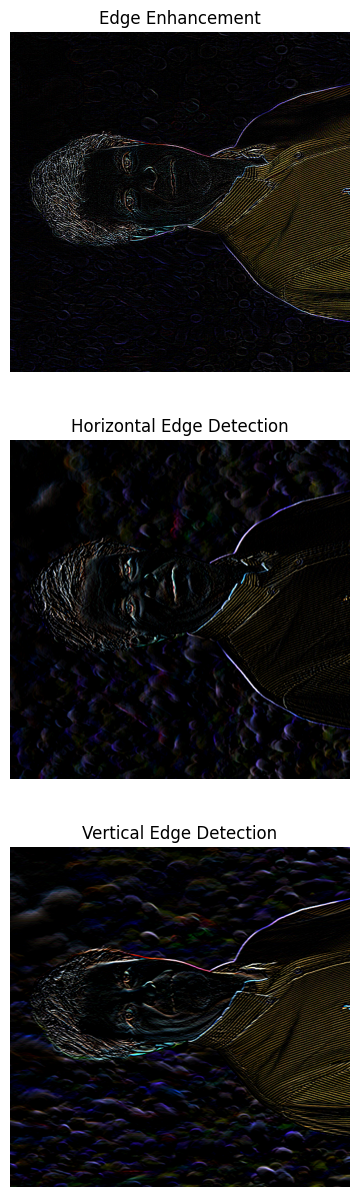

In [7]:
fig = plt.subplots(3, 1, figsize=(10, 15))
feature_map1 = []
for i, (filter_name, kernel) in enumerate(first_layer_filters.items()):
    updated_version = apply_convolution(resized_rgb_image, kernel)
    # opencvOutput = cv2.filter2D(resized_rgb_image, -1, kernel)
    feature_map1.append(updated_version)
    plt.subplot(3,1, i+1)
    # plt.imshow(opencvOutput)
    #To display an image in color, you need to modify the plt.imshow function call to remove the cmap='gray' parameter.
    plt.imshow(np.clip(updated_version, 0, 255).astype(np.uint8), cmap='gray')
    plt.title(filter_name)
    plt.axis('off')



<div style="text-align: right;", dir="rtl">
در يك feature map استك ميكنيم.
</div>

In [8]:
feature_map1_3d = np.stack(feature_map1, axis=-1)
print(feature_map1_3d.shape)

(598, 598, 3, 3)



<div style="text-align: right;", dir="rtl">
حالا كاري مشابه لايه اول براي هر يك از اعضاي feature map 1 و با اعمال كرنل هاي ديگر انجام ميدهيم و در آخر آن ها را نيز استك ميكنيم.
</div>

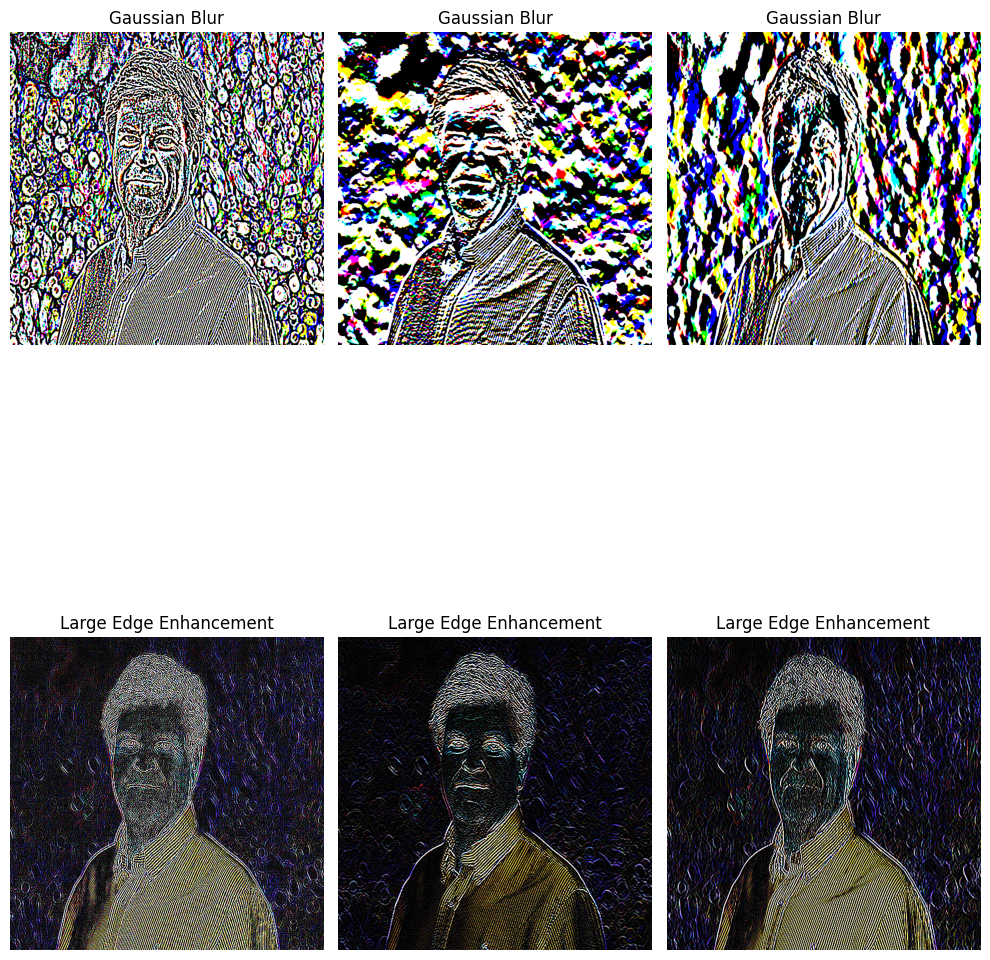

In [9]:
from matplotlib.pyplot import axes
fig, axes = plt.subplots(2, 3, figsize=(10, 15))


feature_map2 = []
for i, (filter_name, kernel) in enumerate(second_layer_filters.items()):
    for j,first_layer_result in enumerate(feature_map1):
        updated_version = apply_convolution(first_layer_result, kernel)
        # opencvOutput = cv2.filter2D(first_layer_result, -1,kernel)
        # blur = cv.GaussianBlur(img,(5,5),0)
        feature_map2.append(updated_version)
        ax=axes[i,j]
        # plt.imshow(opencvOutput)
        #To display an image in color, you need to modify the plt.imshow function call to remove the cmap='gray' parameter.
        ax.imshow(np.clip(updated_version, 0, 255).astype(np.uint8), cmap='gray')
        ax.set_title(filter_name)
        ax.axis('off')
plt.tight_layout()
plt.show()

In [10]:
feature_map2_3d = np.stack(feature_map2, axis=-1)


<div style="text-align: right;", dir="rtl">
حالا بايد max poolingرا پياده سازي كنيم. پياده سازي آن مثل كانوولوشت است با اين تفاوت كه در نهايت از بين ماتيريس مقدار ماكسيمم را انتخاب ميكنيم مه اينكه آن را ضرب كنيم.
</div>

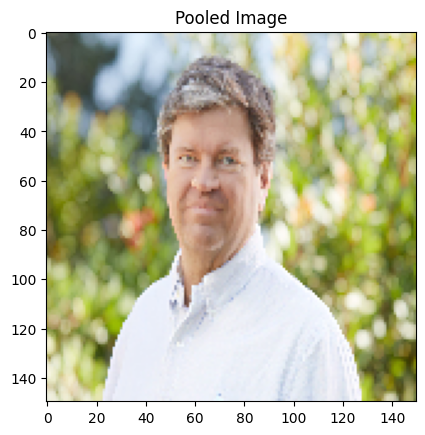

In [23]:
def max_pooling(image, size, stride):
    # Extract dimensions
    image_height, image_width, image_channels = image.shape
    output_height = (image_height - size) // stride + 1
    output_width = (image_width - size) // stride + 1
    
    # Initialize the output
    pooled_image = np.zeros((output_height, output_width, image_channels))
    
    # Perform max pooling
    # for y in range(0, output_height, stride):
    #     for x in range(0, output_width, stride):
    #         for c in range(image_channels):
    #             pooled_image[y, x, c] = np.max(image[y:y+size, x:x+size, c])
    for c in range(image_channels):
        pooled_image[:,:,c]=(image[:image_height, :image_width,c].reshape(output_height, size, output_width, size).max(axis=(1, 3)))
    return pooled_image
pooled_image = max_pooling(resized_rgb_image, size=4, stride=4)
plt.imshow(pooled_image.astype(np.uint8))
plt.title('Pooled Image')
plt.show()



<div style="text-align: right;", dir="rtl">
در اين قسمت تابع max_pooling را امتحان ميكنيم.
</div>

(594, 594, 3, 6)
5


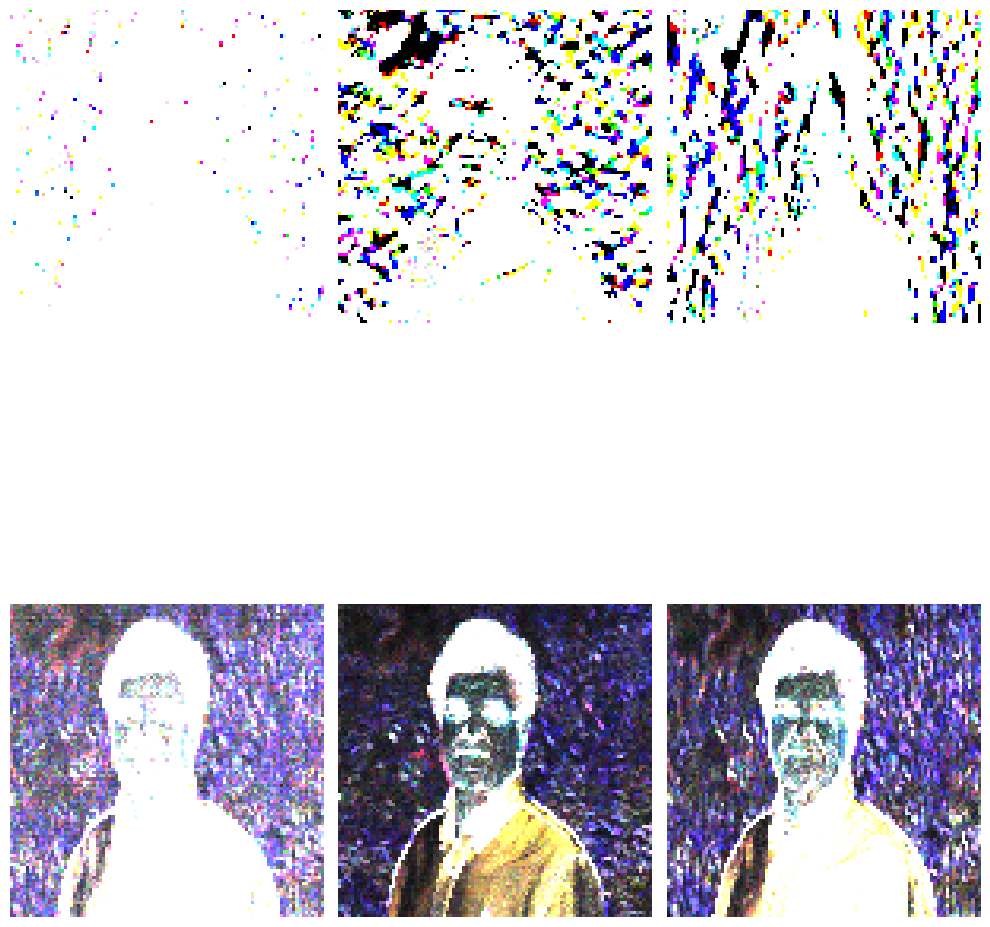

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(10, 15))
print(feature_map2_3d.shape)
features=feature_map2_3d.shape[3]
print(i)
for i in range(features):
        second_layer_result=feature_map2_3d[:,:,:,i]
        updated_version =max_pooling(second_layer_result,6,6)
        ax=axes[i//3,i%3]
        #To display an image in color, you need to modify the plt.imshow function call to remove the cmap='gray' parameter.
        ax.imshow(np.clip(updated_version, 0, 255).astype(np.uint8), cmap='gray')
        ax.axis('off')
plt.tight_layout()
plt.show()